https://viblo.asia/p/maskrcnn-cac-buoc-trien-khai-training-model-maskrcnn-cho-bai-toan-segmentation-WAyK824nlxX

https://medium.com/data-science/train-mask-rcnn-net-for-object-detection-in-60-lines-of-code-9b6bbff292c3

# Dataset

In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="gaB102fGQBWerkKpQYJg")
project = rf.workspace("outsource-lvhq6").project("osteoporosis_segmentation")
version = project.version(2)
dataset = version.download("coco-segmentation")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to osteoporosis_segmentation-2 in coco-segmentation:: 100%|████████████████████████████████████| 430/430 [00:00<00:00, 16791.27it/s]


In [1]:
from pycocotools.coco import COCO
import torch
from torch.utils.data import Dataset
import os
import cv2

class COCOSegmentationDataset(Dataset):
    def __init__(self, root, annFile, transforms=None):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']

        img = cv2.imread(os.path.join(self.root, path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        masks = []
        boxes = []
        for ann in anns:
            mask = coco.annToMask(ann)
            masks.append(mask)
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(anns),), dtype=torch.int64)  # 1 class

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = torch.tensor([img_id])

        if self.transforms:
            img, target = self.transforms(img, target)

        img = torch.as_tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0
        return img, target

    def __len__(self):
        return len(self.ids)

# Model and training

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # Now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model

num_classes = 2  # 1 class (object) + background
model = get_model_instance_segmentation(num_classes)

In [3]:
from torch.utils.data import DataLoader
import pandas as pd
import os
import torch

dataset = COCOSegmentationDataset(
    root="osteoporosis_segmentation-2/train",
    annFile="osteoporosis_segmentation-2/train/_annotations.coco.json"
)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

output_dir = "runs/segment"
csv_path = os.path.join(output_dir, "train_log_maskrcnn.csv")
last_ckpt = os.path.join(output_dir, "maskrcnn_last.pth")

optimizer_path = os.path.join(output_dir, "optimizer_last.pth")
if os.path.exists(optimizer_path):
    optimizer.load_state_dict(torch.load(optimizer_path))

start_epoch = 0
best_loss = float('inf')

# Nếu có checkpoint thì load lại model và optimizer
if os.path.exists(last_ckpt):
    print(f"Loading checkpoint from {last_ckpt}")
    model.load_state_dict(torch.load(last_ckpt))
    # Nếu bạn muốn load cả optimizer, hãy lưu optimizer.state_dict() khi save và load lại ở đây
    # optimizer.load_state_dict(torch.load(os.path.join(output_dir, "optimizer_last.pth")))
    # Đọc epoch cuối cùng từ csv
    if os.path.exists(csv_path):
        import pandas as pd
        df = pd.read_csv(csv_path)
        if not df.empty:
            start_epoch = int(df["epoch"].max())
            best_loss = float(df["loss"].min())

for epoch in range(start_epoch, 1000):
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    if losses.item() < best_loss:
        best_loss = losses.item()
        torch.save(model.state_dict(), os.path.join(output_dir, f"maskrcnn_best.pth"))
    torch.save(model.state_dict(), os.path.join(output_dir, f"maskrcnn_last.pth"))
    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer_last.pth"))  # Nếu muốn lưu optimizer
    print(f"Epoch {epoch+1}, Loss: {losses.item()}")
    # Ghi log vào csv
    log_row = {"epoch": epoch+1, "loss": losses.item()}
    df = pd.DataFrame([log_row])
    df.to_csv(csv_path, mode='a', header=False, index=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Using device: cuda:0
Loading checkpoint from runs/segment/maskrcnn_last.pth


/tmp/ipykernel_2911216/2183658157.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


Epoch 72, Loss: 0.05038983374834061
Epoch 73, Loss: 0.052179910242557526
Epoch 74, Loss: 0.05235201120376587
Epoch 75, Loss: 0.05272475630044937
Epoch 76, Loss: 0.062241047620773315
Epoch 77, Loss: 0.054512087255716324
Epoch 78, Loss: 0.054093845188617706
Epoch 79, Loss: 0.0539219044148922
Epoch 80, Loss: 0.05116546154022217
Epoch 81, Loss: 0.04877742379903793
Epoch 82, Loss: 0.05487038567662239
Epoch 83, Loss: 0.054997436702251434
Epoch 84, Loss: 0.04891734570264816
Epoch 85, Loss: 0.047736503183841705
Epoch 86, Loss: 0.04957197979092598
Epoch 87, Loss: 0.04845552146434784
Epoch 88, Loss: 0.04948755353689194
Epoch 89, Loss: 0.04733875393867493
Epoch 90, Loss: 0.04510488361120224
Epoch 91, Loss: 0.05079583823680878


: 

: 

# Test

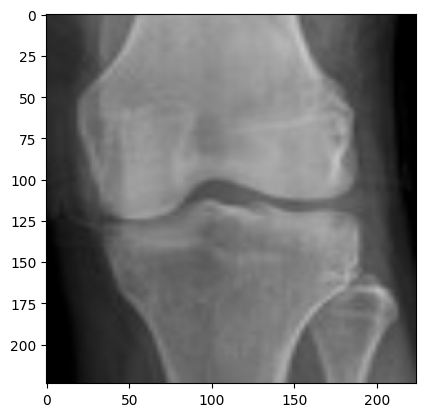

In [2]:
import torch
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# Load image
files = os.listdir("data/Data_x3_ROI/osteoporosis")
img_path = f"data/Data_x3_ROI/osteoporosis/{files[1]}"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.show()

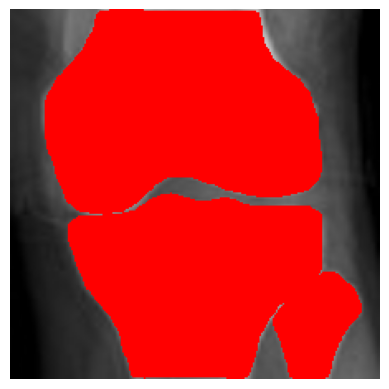

In [5]:
img_tensor = torch.as_tensor(img_rgb, dtype=torch.float32).permute(2, 0, 1) / 255.0
img_tensor = img_tensor.unsqueeze(0)

# Load model
num_classes = 2
model = get_model_instance_segmentation(num_classes)
model.load_state_dict(torch.load("runs/segment/maskrcnn_best.pth", map_location="cpu"))
model.eval()

# Predict
with torch.no_grad():
    prediction = model(img_tensor)

# Visualize
masks = prediction[0]['masks']
scores = prediction[0]['scores']

img_show = img_rgb.copy()
# Tạo một mask tổng hợp
combined_mask = np.zeros(img_show.shape[:2], dtype=bool)

for i in range(len(masks)):
    if scores[i] > 0.5:
        mask = masks[i, 0].cpu().numpy()
        combined_mask = np.logical_or(combined_mask, mask > 0.5)

# Tô màu đỏ lên vùng mask
img_show[combined_mask] = [255, 0, 0]

plt.imshow(img_show)
plt.axis('off')
plt.show()

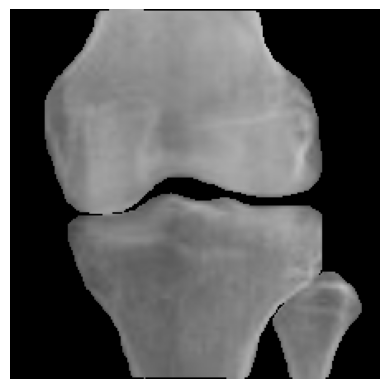

In [6]:
img_masked = img_rgb.copy()
# Đặt ngoài vùng mask về đen
img_masked[~combined_mask] = 0

plt.imshow(img_masked)
plt.axis('off')
plt.show()

# Apply

In [2]:
from tools.seg_detect import seg_process

In [9]:
import os
input_dir = "data/Data_x3_ROI"
output_dir = "data/Data_x3_seg"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(f"{output_dir}/normal", exist_ok=True)
os.makedirs(f"{output_dir}/osteoporosis", exist_ok=True)
out_map = {
    "normal": "normal",
    "osteoporosis": "osteoporosis",
    # "osteopenia": "osteoporosis"
}
cnt = 0
for label in os.listdir(input_dir):
    if label in out_map.keys():
        files = os.listdir(f"{input_dir}/{label}")
        for file in files:
            cnt += 1
            img_path = os.path.join(input_dir, label, file)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            mask_image = seg_process(img_rgb)
            output_path=os.path.join(output_dir, out_map[label], file)
            print(output_path, mask_image.shape)
            cv2.imwrite(output_path, mask_image)
print(cnt)

data/Data_x3_ROI/normal/135_orig_roi1.png (224, 224, 3)
data/Data_x3_seg/normal/135_orig_roi1.png (224, 224, 3)
data/Data_x3_ROI/normal/Normal 330_aug3_roi1.png (224, 224, 3)
data/Data_x3_seg/normal/Normal 330_aug3_roi1.png (224, 224, 3)
data/Data_x3_ROI/normal/218n_aug1_roi1.png (224, 224, 3)
data/Data_x3_seg/normal/218n_aug1_roi1.png (224, 224, 3)
data/Data_x3_ROI/normal/Normal 545_aug2_roi1.png (224, 224, 3)
data/Data_x3_seg/normal/Normal 545_aug2_roi1.png (224, 224, 3)
data/Data_x3_ROI/normal/Normal 175_aug2_roi1.png (224, 224, 3)
data/Data_x3_seg/normal/Normal 175_aug2_roi1.png (224, 224, 3)
data/Data_x3_ROI/normal/Normal 235_aug3_roi1.png (224, 224, 3)
data/Data_x3_seg/normal/Normal 235_aug3_roi1.png (224, 224, 3)
data/Data_x3_ROI/normal/N26_aug3_roi1.png (224, 224, 3)
data/Data_x3_seg/normal/N26_aug3_roi1.png (224, 224, 3)
data/Data_x3_ROI/normal/Normal 679_orig_roi1.png (224, 224, 3)
data/Data_x3_seg/normal/Normal 679_orig_roi1.png (224, 224, 3)
data/Data_x3_ROI/normal/Normal 6